In [1]:
import os
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model

# ==========================================
# CONFIGURATION
# ==========================================
DATA_FILE = 'my_synthetic_dataset.mat'

# --- RENAMED MODELS FOR CLARITY ---
# 1. The Standard: Simple model, standard training
FILE_STANDARD = 'AMC_Standard_CNN_AllData.h5'

# 2. The "Lab Only": Complex model, trained only on clean data
FILE_COMPLEX_CLEAN = 'AMC_Complex_CNN_CleanDataOnly.h5'

# 3. The Solution: Optimized V2 model, standard training
FILE_OPTIMIZED = 'AMC_Optimized_V2_AllData.h5'

# 4. The "Fair Weather": Complex model, trained only on >0dB
FILE_COMPLEX_POS_SNR = 'AMC_Complex_CNN_PosSNR.h5'

# Hyperparameters (Tuned for Big Data)
BATCH_STD   = 64   
BATCH_LARGE = 256  
BATCH_SMALL = 32   
EPOCHS      = 30   

print("Configuration set. Model names updated.")


Configuration set. Model names updated.


In [2]:
def load_dataset(filename):
    print(f"Loading data from {filename}...")
    if not os.path.exists(filename):
        print(f"ERROR: {filename} not found! Please run the MATLAB script first.")
        return None, None, None, None

    data = scipy.io.loadmat(filename)
    X = data['X'] 
    Y = data['Y'] 
    Z = data['Z'] # SNR
    
    # Flatten classes list (Fixes the MATLAB format issue)
    classes = data['mods'].ravel() 
    class_names = [c[0] if c.size > 0 else "Unknown" for c in classes]
    
    print(f"Data Loaded. Shape: {X.shape}")
    print(f"Classes: {class_names}")
    return X, Y, Z, class_names

# Execute Load
X, Y, Z, class_names = load_dataset(DATA_FILE)
INPUT_SHAPE = (128, 2)
NUM_CLASSES = len(class_names)

Loading data from my_synthetic_dataset.mat...
Data Loaded. Shape: (90000, 128, 2)
Classes: ['BPSK', 'QPSK', '16QAM']


In [3]:
# 1. Standard Split (80% Train, 20% Test)
# This is what the Standard and Optimized models will use
X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(
    X, Y, Z, test_size=0.2, random_state=42, shuffle=True, stratify=Y
)

# 2. "Clean Only" Subset (SNR >= 5dB)
# Used to force the Complex model to overfit
idx_clean = np.where(Z_train >= 5)[0]
X_train_clean = X_train[idx_clean]
Y_train_clean = Y_train[idx_clean]

# 3. "Positive Only" Subset (SNR > 0dB)
# Used to test if "Fair Weather" training works
idx_pos = np.where(Z_train > 0)[0]
X_train_pos = X_train[idx_pos]
Y_train_pos = Y_train[idx_pos]

print(f"Data Splits Ready:")
print(f" - Standard Train Size: {len(X_train)}")
print(f" - Clean Train Size:    {len(X_train_clean)}")
print(f" - >0dB Train Size:     {len(X_train_pos)}")

Data Splits Ready:
 - Standard Train Size: 72000
 - Clean Train Size:    33421
 - >0dB Train Size:     43090


In [4]:
def build_standard_cnn(input_shape, num_classes):
    """The Baseline: Simple, effective, lightweight."""
    model = models.Sequential([
        layers.Conv1D(64, 3, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(2),
        layers.Conv1D(16, 3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_complex_cnn(input_shape, num_classes):
    """The Overfitter: Too deep, too many parameters, no batch norm."""
    model = models.Sequential([
        layers.Conv1D(128, 3, padding='same', activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(2),
        layers.Conv1D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling1D(2),
        layers.Conv1D(64, 3, padding='same', activation='relu'),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_optimized_v2_cnn(input_shape, num_classes):
    """
    The Solution (V2): 
    - Deeper than Standard
    - Batch Normalization for stability
    - Tuned Dropout (0.2) for Big Data
    """
    model = models.Sequential([
        # Block 1
        layers.Conv1D(64, 3, padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling1D(2),
        
        # Block 2
        layers.Conv1D(64, 3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling1D(2),
        
        # Block 3
        layers.Conv1D(32, 3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling1D(2),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2), 
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
def manage_model(name, filename, builder_func, input_shape, num_classes, X_t, Y_t, X_v, Y_v, batch_size):
    print(f"\n--- Managing {name} ---")
    model = None
    should_train = True
    
    if os.path.exists(filename):
        choice = input(f"Found '{filename}'. Load it? (y/n): ").strip().lower()
        if choice == 'y':
            print(f"Loading {name}...")
            model = load_model(filename)
            should_train = False
    
    if should_train:
        print(f"Training {name}...")
        model = builder_func(input_shape, num_classes)
        model.fit(X_t, Y_t, 
                  epochs=EPOCHS, 
                  batch_size=batch_size, 
                  validation_data=(X_v, Y_v),
                  verbose=1)
        model.save(filename)
        print(f"Saved {filename}")
        
    return model

In [6]:
# 1. Standard Baseline (Standard Arch + All Data)
model_std = manage_model(
    "Standard CNN", FILE_STANDARD, build_standard_cnn,
    INPUT_SHAPE, NUM_CLASSES, X_train, Y_train, X_test, Y_test, BATCH_STD
)

# 2. Complex/Overfit (Complex Arch + Clean Data Only)
model_clean = manage_model(
    "Complex CNN (Clean Data)", FILE_COMPLEX_CLEAN, build_complex_cnn,
    INPUT_SHAPE, NUM_CLASSES, X_train_clean, Y_train_clean, X_test, Y_test, BATCH_SMALL
)

# 3. Optimized V2 (Optimized Arch + All Data)
model_opt = manage_model(
    "Optimized V2", FILE_OPTIMIZED, build_optimized_v2_cnn,
    INPUT_SHAPE, NUM_CLASSES, X_train, Y_train, X_test, Y_test, BATCH_LARGE
)

# 4. Complex/PosSNR (Complex Arch + >0dB Data Only)
model_pos = manage_model(
    "Complex CNN (>0dB Data)", FILE_COMPLEX_POS_SNR, build_complex_cnn, 
    INPUT_SHAPE, NUM_CLASSES, X_train_pos, Y_train_pos, X_test, Y_test, BATCH_SMALL
)


--- Managing Standard CNN ---
Training Standard CNN...



Epoch 1/30


1125/1125 [==============================] - 4s 3ms/step - loss: 0.8182 - accuracy: 0.5314 - val_loss: 0.6515 - val_accuracy: 0.6011
Epoch 2/30
1125/1125 [==============================] - 4s 3ms/step - loss: 0.6436 - accuracy: 0.6046 - val_loss: 0.6252 - val_accuracy: 0.6079
Epoch 3/30
1125/1125 [==============================] - 4s 3ms/step - loss: 0.5825 - accuracy: 0.6701 - val_loss: 0.4759 - val_accuracy: 0.7531
Epoch 4/30
1125/1125 [==============================] - 4s 3ms/step - loss: 0.4795 - accuracy: 0.7487 - val_loss: 0.4451 - val_accuracy: 0.7660
Epoch 5/30
1125/1125 [==============================] - 4s 4ms/step - loss: 0.4564 - accuracy: 0.7560 - val_loss: 0.4287 - val_accuracy: 0.7684
Epoch 6/30
1125/1125 [==============================] - 4s 4ms/step - loss: 0.4458 - accuracy: 0.7630 - val_loss: 0.4274 - val_accuracy: 0.7779
Epoch 7/30
1125/1125 [==============================] - 4s 3ms/step - loss:

c:\Users\PADIDAR\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/30
1045/1045 [==============================] - 28s 25ms/step - loss: 0.3963 - accuracy: 0.7759 - val_loss: 3.0822 - val_accuracy: 0.6705
Epoch 2/30
1045/1045 [==============================] - 27s 26ms/step - loss: 0.1345 - accuracy: 0.9464 - val_loss: 4.0407 - val_accuracy: 0.6664
Epoch 3/30
1045/1045 [==============================] - 29s 28ms/step - loss: 0.1005 - accuracy: 0.9586 - val_loss: 5.4598 - val_accuracy: 0.6931
Epoch 4/30
1045/1045 [==============================] - 14s 14ms/step - loss: 0.0839 - accuracy: 0.9665 - val_loss: 4.2539 - val_accuracy: 0.7006
Epoch 5/30
1045/1045 [==============================] - 14s 14ms/step - loss: 0.0697 - accuracy: 0.9724 - val_loss: 5.5644 - val_accuracy: 0.7112
Epoch 6/30
1045/1045 [==============================] - 8s 7ms/step - loss: 0.0601 - accuracy: 0.9756 - val_loss: 6.2606 - val_accuracy: 0.7155
Epoch 7/30
1045/1045 [==============================] - 7s 7ms/step - loss: 0.0527 - accuracy: 0.9792 - val_loss: 6.4208 - val

Calculating SNR Curves...


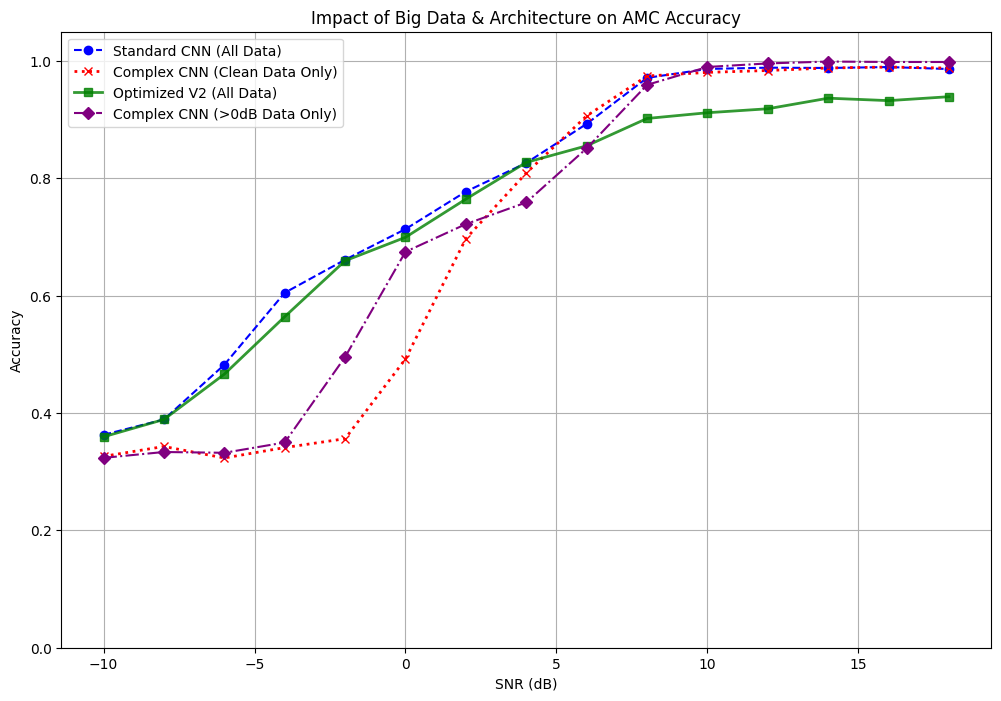

In [7]:
def get_snr_accuracy(model, X, Y, Z, snr_vals):
    acc_list = []
    for snr in snr_vals:
        mask = (Z.flatten() == snr)
        X_sub = X[mask]
        Y_sub = Y[mask]
        if len(X_sub) > 0:
            _, acc = model.evaluate(X_sub, Y_sub, verbose=0)
            acc_list.append(acc)
        else:
            acc_list.append(0)
    return acc_list

print("Calculating SNR Curves...")
snr_values = np.unique(Z)

acc_std   = get_snr_accuracy(model_std, X_test, Y_test, Z_test, snr_values)
acc_clean = get_snr_accuracy(model_clean, X_test, Y_test, Z_test, snr_values)
acc_opt   = get_snr_accuracy(model_opt, X_test, Y_test, Z_test, snr_values)
acc_pos   = get_snr_accuracy(model_pos, X_test, Y_test, Z_test, snr_values)

# Plotting
plt.figure(figsize=(12, 8))

plt.plot(snr_values, acc_std, 'b--', marker='o', label='Standard CNN (All Data)')
plt.plot(snr_values, acc_clean, 'r:', marker='x', linewidth=2, label='Complex CNN (Clean Data Only)')
plt.plot(snr_values, acc_opt,  'g-', marker='s', linewidth=2, alpha=0.8, label='Optimized V2 (All Data)')
plt.plot(snr_values, acc_pos, color='purple', marker='D', linestyle='-.', label='Complex CNN (>0dB Data Only)')

plt.title('Impact of Big Data & Architecture on AMC Accuracy')
plt.xlabel('SNR (dB)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim([0, 1.05])
plt.show()

Generating Confusion Matrix for Standard...
563/563 [==============================] - 1s 1ms/step


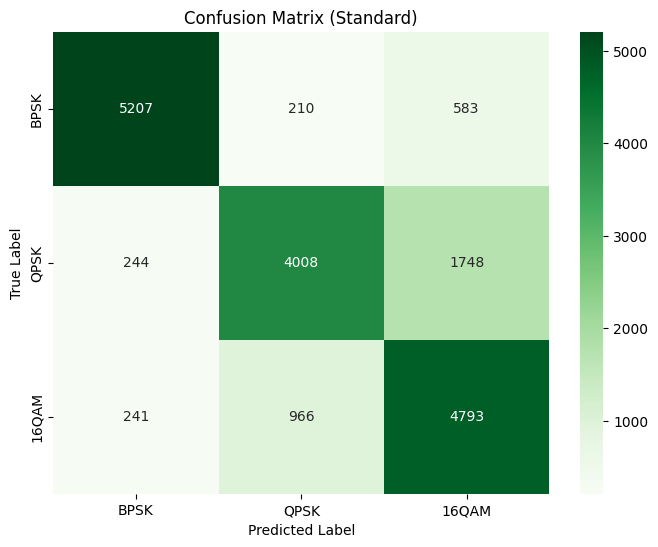

In [9]:
print("Generating Confusion Matrix for Standard...")
y_pred = model_std.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Standard)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()